In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
def add_label_noise(labels, p=0.1):
    num_labels = int(len(labels))
    num_change = int(p * len(labels))
    
    idx = torch.randperm(num_labels)[:num_change]

    new_labels = torch.randint(0, 10, (num_change,))
    labels[idx] = new_labels
    return labels
print(add_label_noise(torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0]), 0.8))

trainset.targets = add_label_noise(torch.tensor(trainset.targets), p=0.15).tolist()

tensor([6, 2, 2, 7, 4, 9, 1, 2, 9, 0])


In [5]:
batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
                                
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

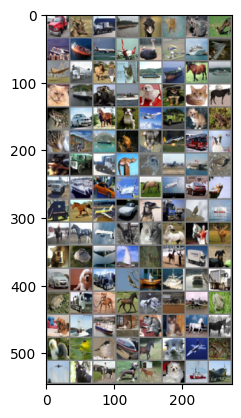

truck deer  truck ship  bird  cat   frog  deer  ship  ship  plane plane bird  plane ship  plane plane truck horse cat   ship  ship  horse ship  cat   ship  truck ship  dog   horse cat   horse frog  car   horse dog   plane truck dog   frog  cat   horse ship  frog  dog   plane truck dog   dog   truck truck dog   bird  plane ship  bird  truck ship  car   plane horse truck car   deer  cat   horse car   car   bird  ship  bird  ship  horse horse dog   cat   cat   frog  horse deer  cat   bird  plane ship  deer  horse truck dog   ship  dog   truck bird  ship  ship  ship  cat   frog  truck dog   cat   horse horse plane frog  dog   ship  ship  cat   cat   cat   horse horse dog   bird  frog  plane horse bird  plane frog  plane cat   horse dog   horse dog   ship  dog  


In [6]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
from resnet import ResNet

In [8]:
def estimate_loss(net, split="train"):
    if split == "train":
        loader = trainloader
    else:
        loader = testloader
    loss = 0
    n_correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += F.cross_entropy(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)

            n_correct += (predicted == labels).sum().item()
            total += labels.size(0)

    net.train()
    return loss / len(loader), (1 - (n_correct / total))

In [9]:
def run_experiment(k=64, epochs=10):
    net = ResNet(k).to(device)
    n_params = sum(p.numel() for p in net.parameters())
    print(f'Width: {k}')
    print(f'Number of parameters: {n_params}')

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

    test_lossi = []
    lossi = []
    test_erri = []
    train_erri = []

    test_loss, test_error = estimate_loss(net, "test")
    test_lossi.append(test_loss)
    test_erri.append(test_error)

    train_loss, train_error = estimate_loss(net, "train")
    lossi.append(train_loss)
    train_erri.append(train_error)

    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        total = 0
        correct = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = net(inputs)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                lossi.append(running_loss / 100)
                running_loss = 0.0

                train_error = 1 - (correct / total)
                train_erri.append(train_error)
                total = 0
                correct = 0

                print(f'[{epoch + 1}, {i + 1:5d}] running loss: {running_loss / 100:.3f}, loss: {loss.item():.3f}, train error: {train_error:.3f}')
        
        test_loss, test_err = estimate_loss(net, "test")
        test_lossi.append(test_loss)
        test_erri.append(test_err)
        print(f'[{epoch + 1}] test loss: {test_loss:.3f}, test error: {test_err:.3f}')
    
    return net, lossi, test_lossi, train_erri, test_erri


In [10]:
# testing
# net, lossi, test_lossi = run_experiment(16, 5)

In [11]:
# plt.plot(lossi, torch.arange(len(lossi)) / len(test_lossi), label='train')
# xs = torch.arange(len(lossi)) * ((len(test_lossi) - 1) / (len(lossi) - 1))
# print(len(lossi), len(test_lossi))
# print(xs, len(xs))
# # plt.plot(lossi, xs, label='train')
# plt.plot(xs, lossi)
# plt.plot(test_lossi, label='test')
# plt.legend()
# plt.show()

In [12]:
epochs = 128
sizes = list(range(4, 37, 8))
print("sizes:", sizes)

losses = {}

for size in sizes:
    print(f'Running experiment with width {size}')
    net, lossi, test_lossi, train_err, test_err = run_experiment(size, epochs)
    losses[size] = (lossi, test_lossi, train_err, test_err)

    print(f'Finished experiment with width {size}')
    print('\n\n\n\n\n')
    del net

sizes: [4, 12, 20, 28, 36]
Running experiment with width 4
Width: 4
Number of parameters: 44570
[1,   100] running loss: 0.000, loss: 2.106, train error: 0.825
[1,   200] running loss: 0.000, loss: 2.008, train error: 0.762
[1,   300] running loss: 0.000, loss: 1.952, train error: 0.746
[1] test loss: 1.812, test error: 0.680
[2,   100] running loss: 0.000, loss: 1.892, train error: 0.701
[2,   200] running loss: 0.000, loss: 1.875, train error: 0.684
[2,   300] running loss: 0.000, loss: 1.988, train error: 0.681
[2] test loss: 1.683, test error: 0.625
[3,   100] running loss: 0.000, loss: 1.808, train error: 0.668
[3,   200] running loss: 0.000, loss: 1.808, train error: 0.649
[3,   300] running loss: 0.000, loss: 1.720, train error: 0.650
[3] test loss: 1.619, test error: 0.589
[4,   100] running loss: 0.000, loss: 1.784, train error: 0.633
[4,   200] running loss: 0.000, loss: 1.704, train error: 0.629
[4,   300] running loss: 0.000, loss: 1.710, train error: 0.624
[4] test loss: 1

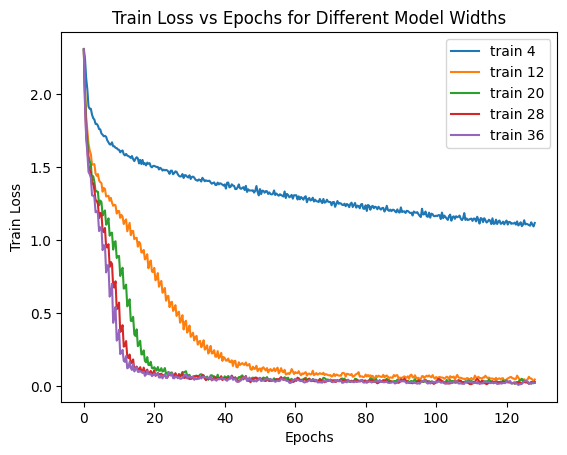

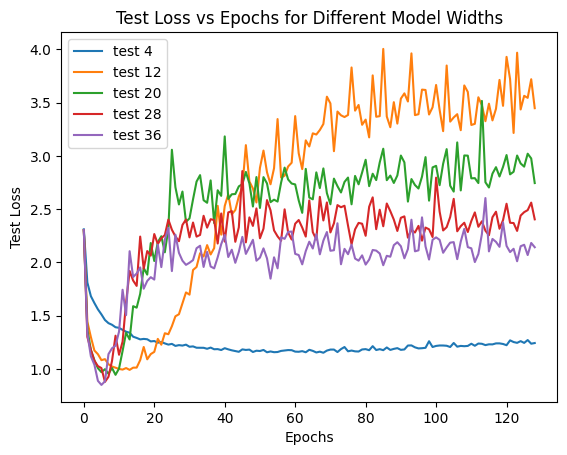

In [18]:
for size in sizes:
    lossi = losses[size][0]
    xs = torch.arange(len(lossi)) * ((len(test_lossi) - 1) / (len(lossi) - 1))
    plt.plot(xs, lossi, label=f'train {size}')

plt.title('Train Loss vs Epochs for Different Model Widths')
plt.ylabel('Train Loss')
plt.xlabel('Epochs')

plt.legend()
plt.show()


for size in sizes:
    test_lossi = losses[size][1]
    plt.plot(test_lossi, label=f'test {size}')

plt.title('Test Loss vs Epochs for Different Model Widths')
plt.ylabel('Test Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

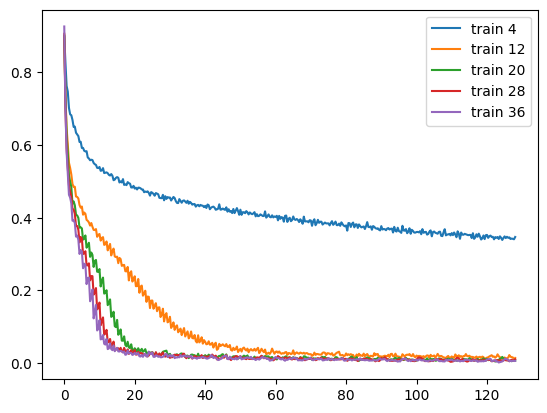

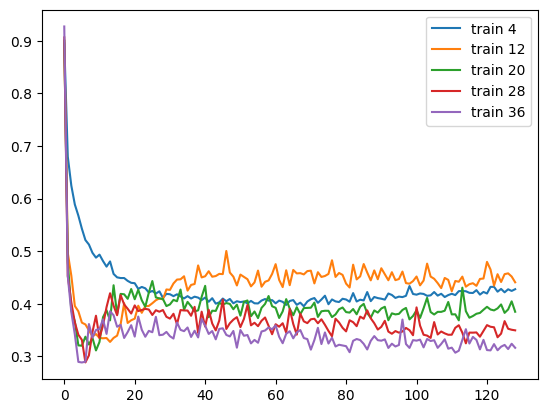

In [19]:
for size in sizes:
    lossi = losses[size][2]
    xs = torch.arange(len(lossi)) * ((len(test_lossi) - 1) / (len(lossi) - 1))
    plt.plot(xs, lossi, label=f'train {size}')
plt.legend()
plt.show()

for size in sizes:
    lossi = losses[size][3]
    xs = torch.arange(len(lossi)) * ((len(test_lossi) - 1) / (len(lossi) - 1))
    plt.plot(xs, lossi, label=f'train {size}')

plt.legend()
plt.show()


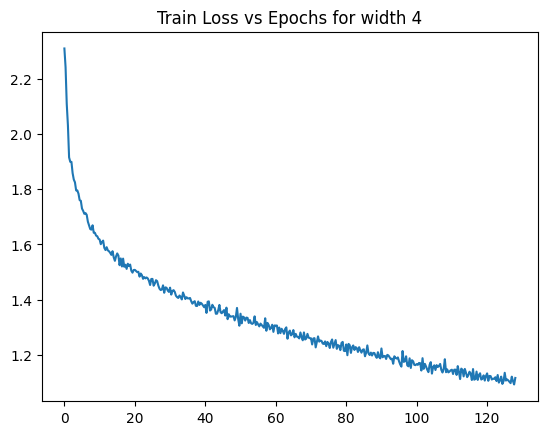

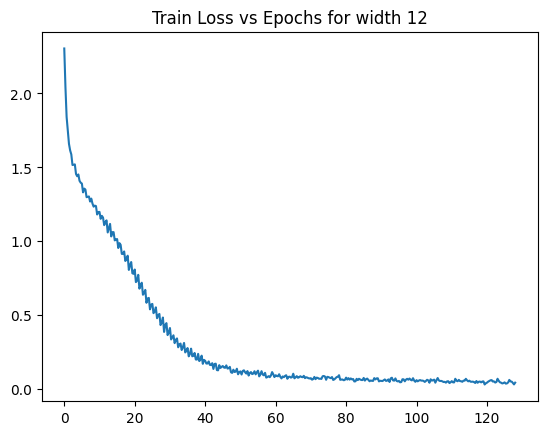

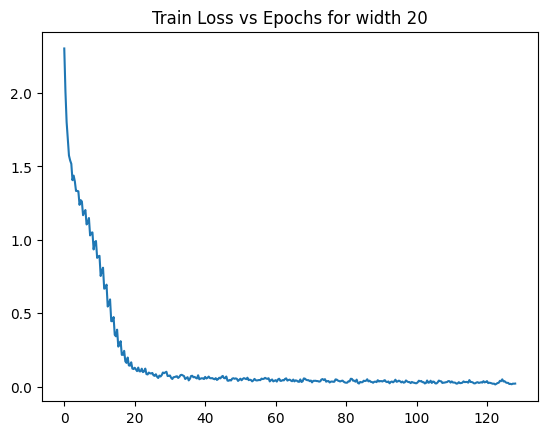

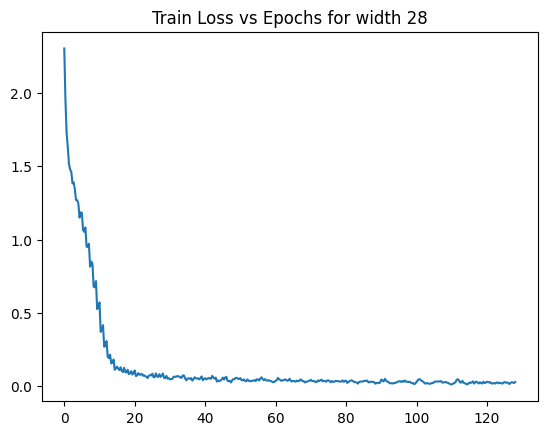

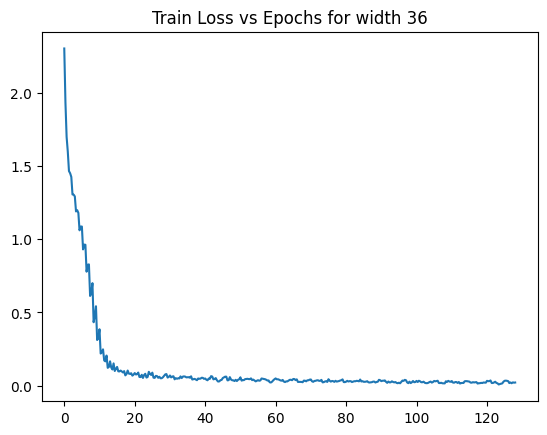

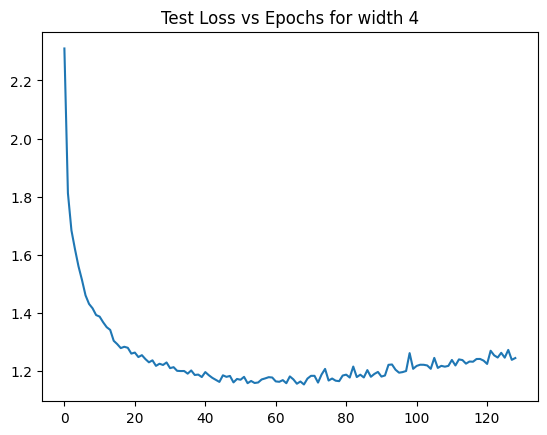

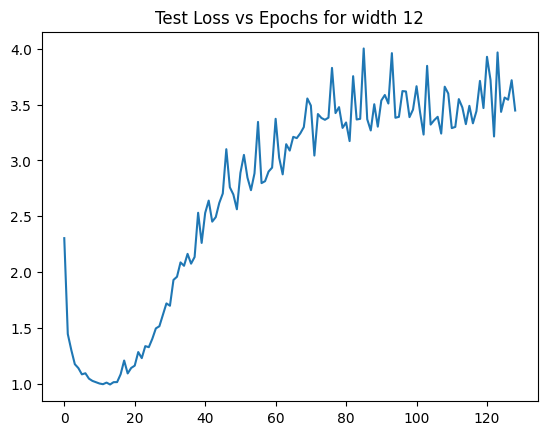

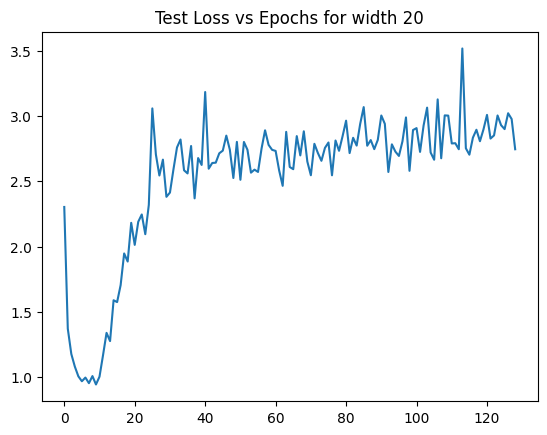

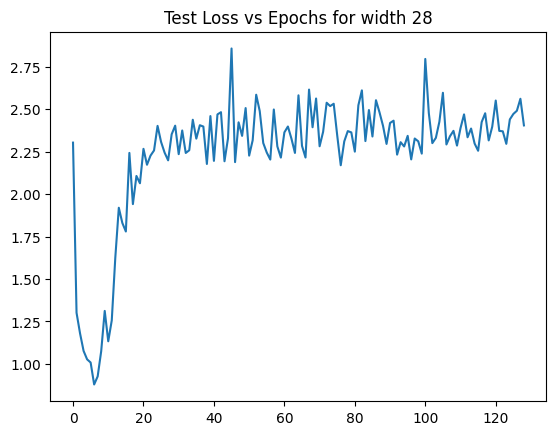

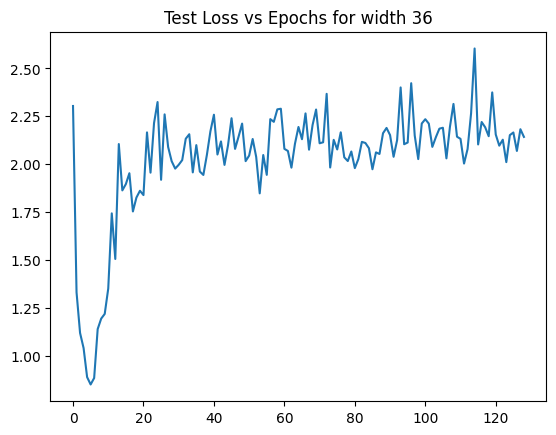

In [15]:
for size in sizes:
    lossi = losses[size][0]
    xs = torch.arange(len(lossi)) * ((len(test_lossi) - 1) / (len(lossi) - 1))
    plt.plot(xs, lossi, label=f'train {size}')
    plt.title(f'Train Loss vs Epochs for width {size}')
    plt.show()
    
for size in sizes:
    test_lossi = losses[size][1]
    plt.plot(test_lossi, label=f'test {size}')
    plt.title(f'Test Loss vs Epochs for width {size}')
    plt.show()

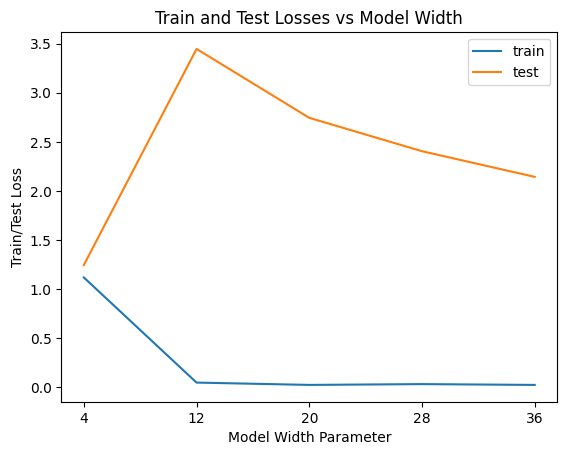

In [16]:
last_test_losses = [losses[size][1][-1] for size in sizes]
last_train_losses = [losses[size][0][-1] for size in sizes]

plt.title("Train and Test Losses vs Model Width")
plt.plot(sizes, last_train_losses, label='train')
plt.plot(sizes, last_test_losses, label='test')

plt.xticks(sizes)
plt.xlabel('Model Width Parameter')
plt.ylabel('Train/Test Loss')

plt.legend()
plt.show()

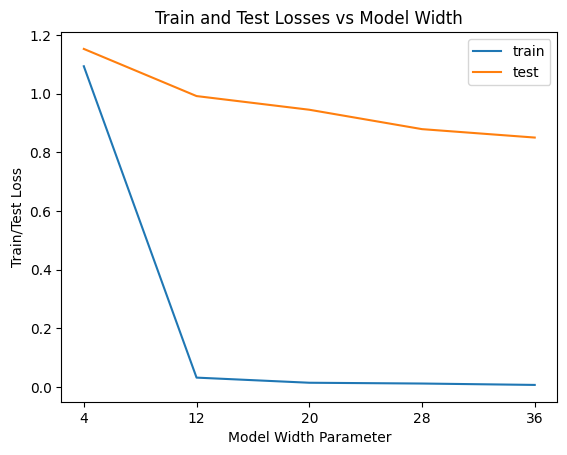

In [17]:

last_test_losses = [min(losses[size][1]) for size in sizes]
last_train_losses = [min(losses[size][0]) for size in sizes]

plt.title("Train and Test Losses vs Model Width")
plt.plot(sizes, last_train_losses, label='train')
plt.plot(sizes, last_test_losses, label='test')

plt.xticks(sizes)
plt.xlabel('Model Width Parameter')
plt.ylabel('Train/Test Loss')

plt.legend()
plt.show()

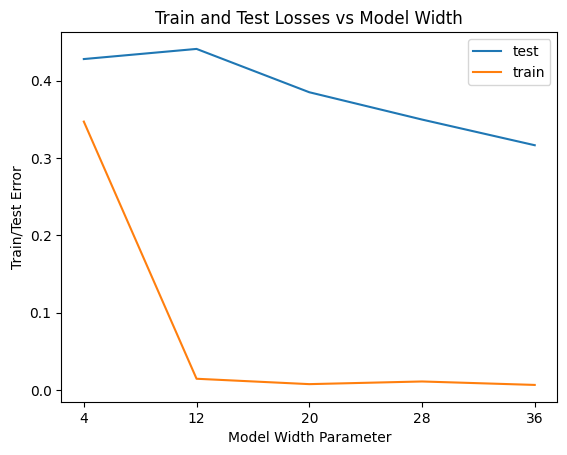

In [22]:
# last_test_err = [min(losses[size][3]) for size in sizes]
# last_train_err = [min(losses[size][2]) for size in sizes]
last_test_err = [losses[size][3][-1] for size in sizes]
last_train_err = [losses[size][2][-1] for size in sizes]

plt.title("Train and Test Losses vs Model Width")
plt.plot(sizes, last_test_err, label='test')
plt.plot(sizes, last_train_err, label='train')

plt.xticks(sizes)
plt.xlabel('Model Width Parameter')
plt.ylabel('Train/Test Error')

plt.legend()
plt.show()